# Lista 1 de Dinâmica Estocástica

Danilo Lessa Bernardineli (NUSP 8944411)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from pylab import rcParams
rcParams['figure.figsize'] = (15, 5) # Ajuste do tamanho das figuras

## Exercício 1.17

Gerar números distribuídos de acordo com a distribuição gaussiana de largura $\sigma = 1$, fazer um histograma e comparar com a curva analítica

In [2]:
N = int(1e2)
x = np.random.randn(N)
rang = (np.min(x), np.max(x))
x_anal = np.linspace(rang[0], rang[1], N)
y_anal = st.norm.pdf(x_anal)

plt.hist(x, normed=True, label="Frequência normalizada")
plt.plot(x_anal, y_anal, label="Distribuição da gaussiana")
plt.title("Números aleatórios gaussianos (quantidade: %s)" % N)
plt.legend()
plt.show()

## Exercício 1.18

Descobrir a área de 1/4 de uma esfera e o volume de 1/8 de uma esfera de raio unitário através do método de Monte Carlo e obter uma estimativa de pi

In [3]:
N = int(1e4)
(x, y, z) = np.random.rand(3, N)

area = np.sum(x ** 2 + y ** 2 <= 1) / N
volume = np.sum(x ** 2 + y ** 2 + z ** 2 <= 1) / N
pi1 = area * 4
pi2 = 8 * volume * 3 / 4
print("Área de 1/4 de círculo: %.3f\tPi estimado: %.3f" % (area, pi1))
print("Volume de 1/8 de esfera: %.3f\tPi estimado: %.3f" % (volume, pi2))

Área de 1/4 de círculo: 0.785	Pi estimado: 3.141
Volume de 1/8 de esfera: 0.526	Pi estimado: 3.158


## Exercício 2.1

Gerar uma sequência de números aleatórios $\epsilon_i$ iguais a -1 ou 1 com igual probabilidade. Calcular a frequência $f_n = \frac{(\sum{\epsilon_n})}{n}$ e fazer um gráfico em função dos n gerados. Verificar que $$\lim_{n\to\infty} f_n = 0$$

Repetir o procedimento com os números aleatórios gerados através da distribuição de Lorentz

In [4]:
# Função para calcular a frequência de x conforme iterações na lista e plotar o resultado

def plotar_frequencia(x):
    N = len(x)
    fn = np.zeros(N)

    for i in range(1, len(x)):
        fn[i] = np.sum(x[:i]) / i

    plt.plot(np.arange(N), fn)
    plt.ylabel("$f_n$")
    plt.xlabel("n")
    plt.show()

In [5]:
N = int(1e5)
x_unif = np.random.rand(N) * 2 - 1
x_lorentz = st.cauchy.rvs(size=N)

### Frequência para números gerados aleatórios uniformemente

Nota-se que a frequência rapidamente converge para 0, que é o esperado

In [6]:
plotar_frequencia(x_unif)

### Frequência para números gerados na distribuição de Lorentz 

Nota-se que a frequência não converge para zero, o que é esperado devido ao valor esperado ser indefinido

In [7]:
plotar_frequencia(x_lorentz)

## Exercício 2.2

Gerar uma sequência de números aleatórios $\epsilon_i$ que tomam 0 ou 1 e calcular $z = \frac{\sum{\epsilon_i} - Na}{\sqrt{Nb}}$ em que $a = \frac{1}{2}$ é a media e $b = \frac{1}{4}$ é a variância dos números gerados. Repetir o processo L vezes e fazer histograma dos valores de z. Comparar com a distribuição gaussiana tomando z como parâmetro

In [8]:
# Obtenção de z

L = int(1e4)
z = np.zeros(L)
a = 0.5
b = 0.25
for l in range(L):
    x = np.random.rand(N)
    z[l] = (np.sum(x) - N * a) / np.sqrt(N * b)

In [9]:
# Geração de uma gaussiana para comparação
zmin = np.min(z)
zmax = np.max(z)
x = np.linspace(zmin, zmax, int(1e3))
z.sort()
y = st.norm.pdf(z)

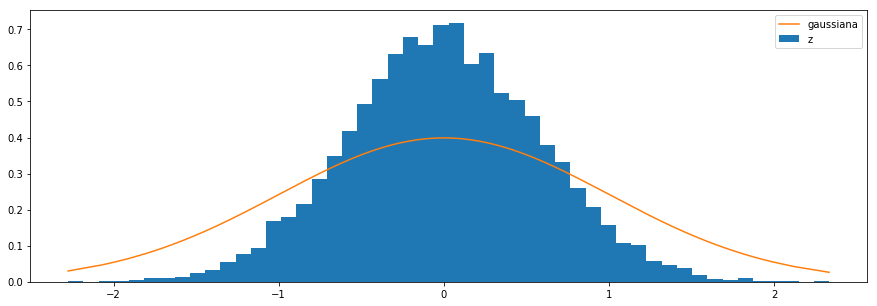

In [10]:
# Geração do gráfico

plt.hist(z, normed=True, bins=50, label="z")
plt.plot(z, y, '-', label="gaussiana")
plt.legend()
plt.show()

## Exercício 3.7

Simular a eq. de Langevin e fazer histogramas da velocidade para tempos muito longos assim como determinar a correlação temporal e fazer um gráfico deste em função de t

In [11]:
# Bloco com a função para simular a eq. de Langevin

def langevin_solve(N=int(1e6), gamma=1, Gamma=None,
                    tau=0.01, epsilon=None):
    """Solves discrete Langevin equation for given parameters"""

    if Gamma is None:
        Gamma = np.array([0.1, 1, 10])

    if epsilon is None:
        epsilon = np.random.randn(N, 1)

    T = np.arange(N) * tau # Elapsed time
    k = np.sqrt(tau * Gamma)

    qtd_Gamma = len(Gamma)
    v = np.zeros((N, qtd_Gamma))

    #Simulação
    for l in range(1, N):
        v[l] = v[l - 1] - tau * gamma * v[l - 1] + k * epsilon[l]
    
    return {"v": v, "t": T, "N": N, "gamma": gamma, "Gamma": Gamma,
            "tau": tau, "epsilon": epsilon}

### Histograma das velocidades para diversos valores de $\Gamma$

In [12]:
# Simulação da eq. de Langevin para Gamma=[0.1, 1, 10] e N=1e4

N = int(1e4)
langevin_output = langevin_solve(N=N)
qtd_Gamma = langevin_output["v"].shape[1]

f, axarr = plt.subplots(1, qtd_Gamma, sharey=True)
plt.suptitle("Histograma de v (N=%.0e)" % N)
for i in range(qtd_Gamma):
    axarr[i].set_title("$\Gamma$ = %s" % langevin_output["Gamma"][i])
    axarr[i].hist(langevin_output["v"][:, i], bins=20)
f.subplots_adjust(hspace=0.5)
plt.show()

In [13]:
# Bloco para calcular a correlação dado um t arbitrário e as velocidades simuladas em uma lista t_mtr

def C(t, v, t_mtr):   
    
    N = len(v)    
    i_t = np.argmin(np.abs(t_mtr - t))
    M = N - i_t
    
    termo_1 = v[:M]
    termo_2 = v[-M:]
    C = np.sum(termo_1 * termo_2)
    
    return C

In [14]:
# Calcular a correlação usando a simulação anterior

v = langevin_output["v"][:, 1]
Gamma = langevin_output["Gamma"][1]
N = len(v)
t_mtr = langevin_output["t"]
c = np.zeros(len(t_mtr))
i = 0
for i in range(0, len(t_mtr) - 1):
    t = t_mtr[i]
    c[i] = C(t, v, t_mtr)

### Gráfico da correlação temporal

In [15]:
# Exibir o resultado

plt.axhline(0, color="r", label="y=0")
plt.plot(t_mtr, c, ',', label="C(t)")
plt.xlabel("t")
plt.ylabel("C(t)")
plt.title("Correlação entre velocidades ($\\tau=%s$, N=%.0e, $\\Gamma=%s$)" %
          (langevin_output["tau"], N, Gamma))
plt.legend()
plt.show()

## Exercício 3.8

Simular a eq. de Langevin com:

a) $f(x)=-c$, $f(x)=0$, $f(x)=c$ sendo que $c>0$

b) $f(x)=-\nu x$

c) $f(x)=ax - bx^3$ sendo que $b>0$

fazer histogramas do x no estado estacionário para diversos valores dos parâmetros


In [16]:
def langevin_f_solve(func, N=int(1e5), gamma=1, tau=0.01,
                         Gamma=None, epsilon=None):
    """Solves Langevin equation with given f(x)"""
    if Gamma is None:
        Gamma = 1
    if epsilon is None:
        epsilon = np.random.randn(N, 1)

    T = np.arange(N) * tau # Tempo decorrido
    k = np.sqrt(tau * Gamma)
    v = np.zeros(N)
    x = np.zeros(N)

    #Simulação
    for l in range(1, N):
        x[l] = x[l-1] + v[l-1] * tau
        f = func(x[l])
        v[l] = v[l - 1] - tau * gamma * v[l - 1] + k * epsilon[l] + f * tau
        
    return {"v": v, "x": x, "t": T, "N": N, "gamma": gamma,
            "Gamma": Gamma, "tau": tau, "epsilon": epsilon}

def langevin_f_solve_wrapper(func):
    """Wrapper for plotting simulation results"""
    N = int(1e5)
    langevin_output = langevin_f_solve(func, N=N)
    v = langevin_output["v"]
    x = langevin_output["x"]
    t = langevin_output["t"]

    f, axarr = plt.subplots(1, 2, sharey=True)
    plt.suptitle("Simulação da eq. de Langevin com N = %.0e" % N)
    axarr[0].set_title("Posição (x)")
    axarr[0].hist(x)
    axarr[1].set_title("Velocidade (v)")
    axarr[1].hist(v)
    f.subplots_adjust(hspace=0.5)
    plt.show()

### Caso f(x) = 5

In [17]:
c = 5
func = lambda x: c
langevin_f_solve_wrapper(func)

### Caso f(x) = 0

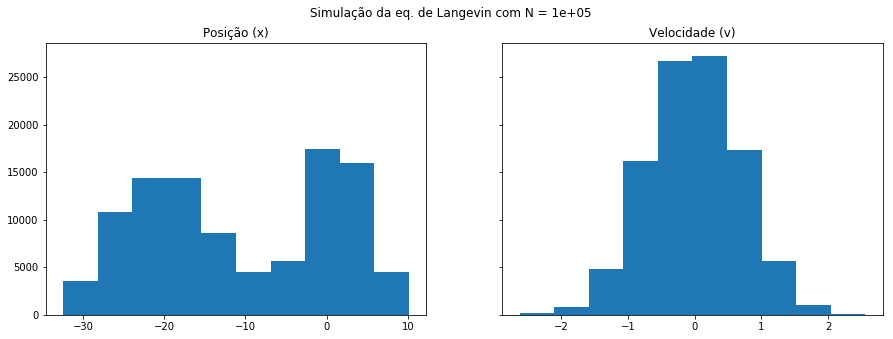

In [18]:
c = 0
func = lambda x: c
langevin_f_solve_wrapper(func)

### Caso f(x) = -5

In [19]:
c = -5
func = lambda x: c
langevin_f_solve_wrapper(func)

### Caso $f(x) = -\nu x$, com $\nu = 5$

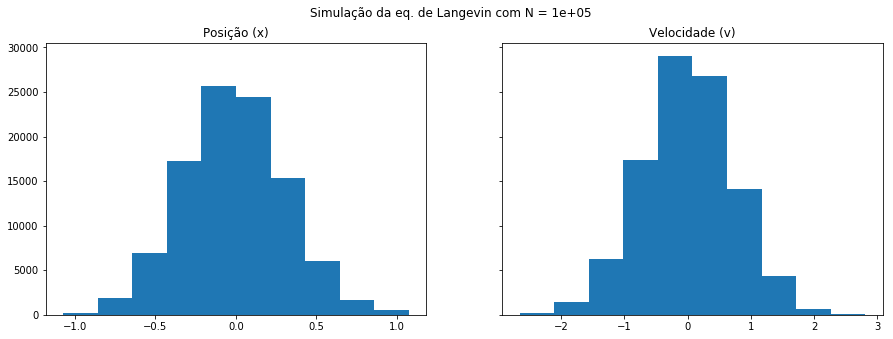

In [20]:
v = 5
func = lambda x: -v * x
langevin_f_solve_wrapper(func)

### Caso $f(x) = ax - bx^3$, com a = 1 e b = 1

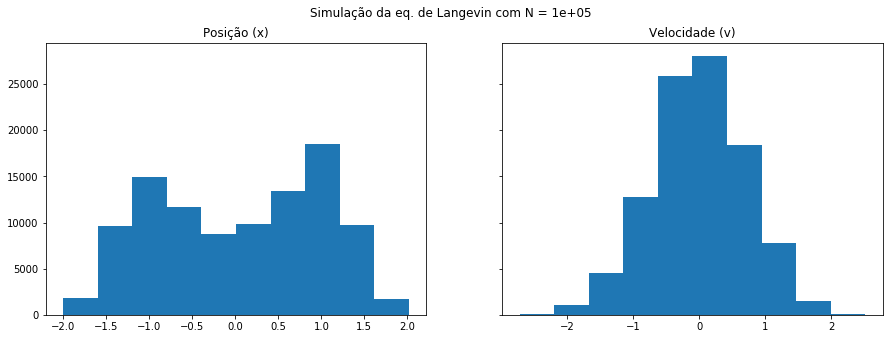

In [21]:
a = 1
b = 1
func = lambda x: a * x - b * x ** 3
langevin_f_solve_wrapper(func)